#### ICFO Spring School 2025
# Hands-on with Qiskit: Hello World - Qiskit Patterns + Sampler Primitive

This example walks you through a Qiskit pattern workflow using the Sampler Qiskit primitive.



## Before you begin

Follow the [Install and set up](https://docs.quantum.ibm.com/guides/install-qiskit) instructions if you haven't already, including the steps to [Set up to use IBM Quantum™ Platform](https://docs.quantum.ibm.com/guides/setup-channel#set-up-to-use-ibm-quantum-platform).

It is recommended that you use the [Jupyter](https://jupyter.org/install) development environment to interact with quantum computers. Be sure to install the recommended extra visualization support (`'qiskit[visualization]'`).The `matplotlib` package is also useful for visualization.

To learn about quantum computing in general, visit the [Basics of quantum information course](https://learning.quantum.ibm.com/course/basics-of-quantum-information) in IBM Quantum Learning.

IBM® is committed to the responsible development of quantum computing. Learn more about responsible quantum at IBM and review our responsible quantum principles in the [Responsible quantum computing and inclusive tech](https://docs.quantum.ibm.com/responsible-quantum-computing) topic.



## Create and run a simple quantum program using the Qiskit pattern framework



The four steps to writing a quantum program using Qiskit patterns are:

1.  Map the problem to a quantum-native format.

2.  Optimize the circuits and operators.

3.  Execute using a Qiskit primitive function. 

4.  Analyze the results.

### Step 1. Map the problem to a quantum-native format

In a quantum program, *quantum circuits* are the native format in which to represent quantum instructions, and *operators* represent the observables to be measured. When creating a circuit, you'll usually create a new [`QuantumCircuit`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#quantumcircuit-class) object, then add instructions to it in sequence.



The following code cell creates a circuit that produces a *Bell state,* which is a state wherein two qubits are fully entangled with each other.

<div class="alert alert-success">

**Step 1** Create a Bell state circuit

</div>


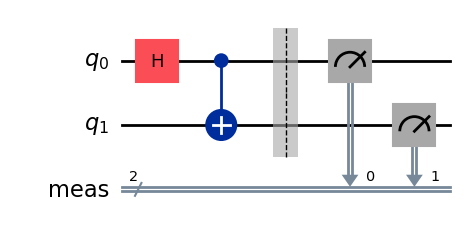

In [1]:
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Create a Bell state circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)

qc.measure_all() # applies measurement operators on all qubits, creates a classical register called `meas`

# Draw the circuit
qc.draw("mpl")

See [`QuantumCircuit`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#quantumcircuit-class) in the documentation for all available operations.



When creating quantum circuits, you must also consider what type of data you want returned after execution. Qiskit provides two ways to return data: you can obtain a probability distribution for a set of qubits you choose to measure, or you can obtain the expectation value of an observable. Prepare your workload to measure your circuit in one of these two ways with [Qiskit primitives](https://docs.quantum.ibm.com/guides/get-started-with-primitives) (explained in detail in [Step 3](#step-3-execute-using-the-quantum-primitives)).

In this example we'll obtain a probability distribution by using the Sampler primitive.

<span id="optimize" />

### Step 2. Optimize the circuits 

When executing circuits on a device, it is important to optimize the set of instructions that the circuit contains and minimize the overall depth (roughly the number of instructions) of the circuit. This ensures that you obtain the best results possible by reducing the effects of error and noise. Additionally, the circuit's instructions must conform to a backend device's [Instruction Set Architecture (ISA)](https://docs.quantum.ibm.com/guides/transpile#instruction-set-architecture) and must consider the device's basis gates and qubit connectivity.

The following code instantiates a simulated version of IBM Quantum's real devices to submit a job to and transforms the circuit and observables to match that backend's ISA.

For this particular example, we'll use the following two devices:

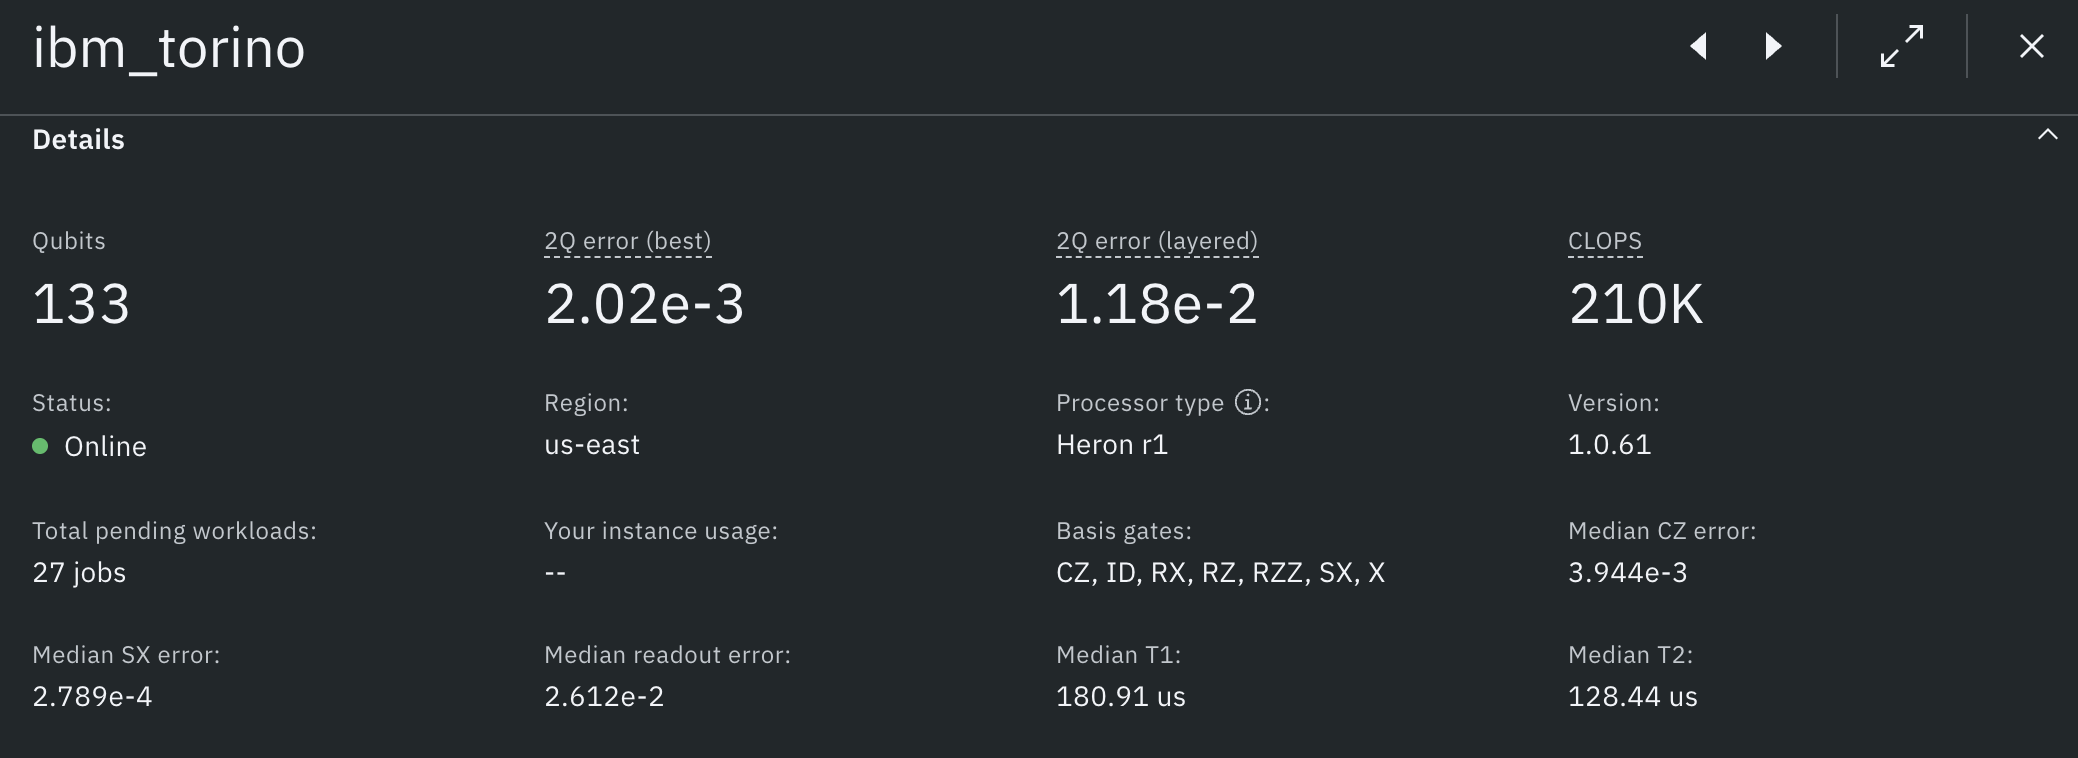

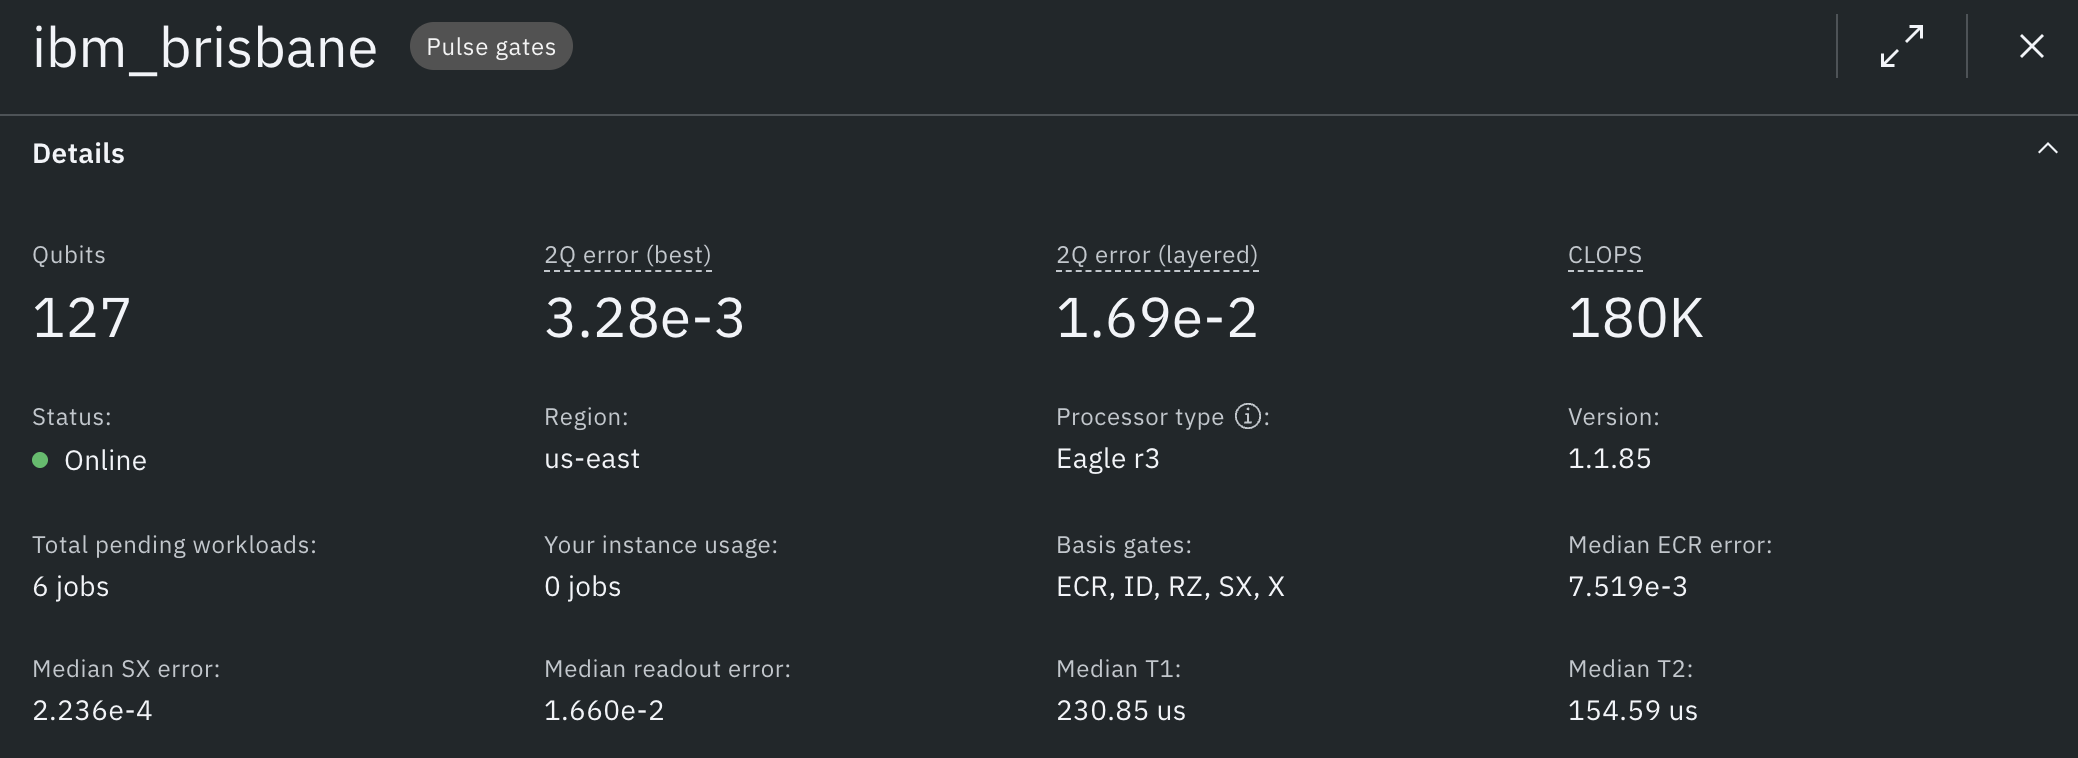

<div class="alert alert-success">

**Step 2** Transpile the circuit into ISA circuit (ISA = Instruction Set Architecture)

</div>

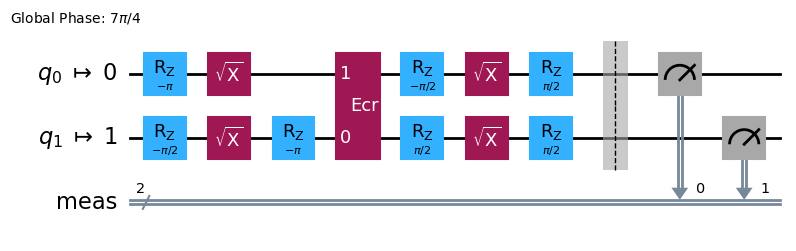

In [2]:
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeBrisbane

# backend = FakeTorino() # assigns your chosen device to be the backend
backend = FakeBrisbane()

sampler = Sampler(backend) # creates a sampler using the selected backend

# Convert to an ISA circuit
pm = generate_preset_pass_manager(backend=backend, optimization_level=1) # generates the pass manager, which is a list of transpiler passes grouped into a logical unit
isa_circuit = pm.run(qc) # runs the pass manager to create the ISA circuit 

isa_circuit.draw("mpl", idle_wires=False) # draws the circuit, note: idle_wires = False to hide all the qubits not being used

### Step 3. Execute using the Qiskit primitives

Quantum computers can produce random results, so you usually collect a sample of the outputs by running the circuit many times. You can estimate the value of the observable by using the `Estimator` class. `Estimator` is one of two [primitives](https://docs.quantum.ibm.com/guides/get-started-with-primitives); the other is `Sampler`, which can be used to get data from a quantum computer.  These objects possess a `run()` method that executes the selection of circuits, observables, and parameters (if applicable), using a [primitive unified bloc (PUB).](https://docs.quantum.ibm.com/guides/primitives#sampler)



<div class="alert alert-success">

**Step 3** Submit a job using the Sampler primitive.

</div>

In [3]:
job = sampler.run([isa_circuit], shots=1024) # runs the sampler primitive on ISA circuit for specified number of shots
result = job.result() # saves the result of the job in the result object

### Step 4. Post-process the results

This step involves postprocessing your results. You might feed these results into another workflow for further analysis or prepare a plot of the key values and data. In general, this step is specific to your problem.  For this example, plot the probability distribution obtained by sampling the quantum circuit as many times as the shots you specified. We do this using `plot_histogram`

<div class="alert alert-success">

**Step 4** Visualize the results using plot_histogram

</div>

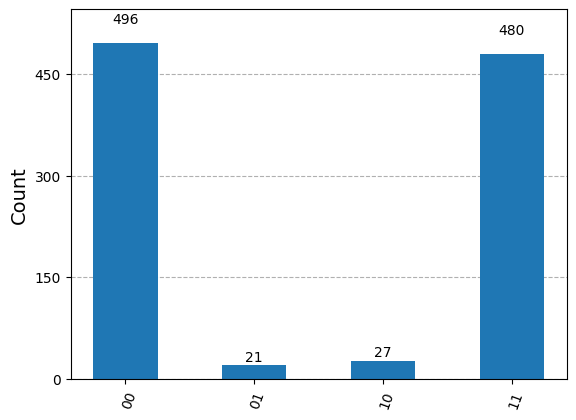

In [4]:
from qiskit.visualization import plot_histogram

counts = result[0].data.meas.get_counts() # meas is the default name of the classical register when using measure_all(). If you specify a classical register, then use the name you assign

# Plot the result
plot_histogram(counts)

<div class="alert alert-info">

We used a simulator for this example. If you'd like to run this code on a real device, you can use the following code.

</div>



In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService

# If you have not previously saved your credentials, follow instructions at
# https://docs.quantum.ibm.com/guides/setup-channel#iqp
# to authenticate with your API token.

# QiskitRuntimeService.save_account(
#     channel="ibm_quantum", 
#     token="<MY_IBM_QUANTUM_TOKEN>", 
#     overwrite=True, 
#     set_as_default=True
# )

service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)

# Convert to an ISA circuit
pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(qc) 

sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=1024)
result = job.result()

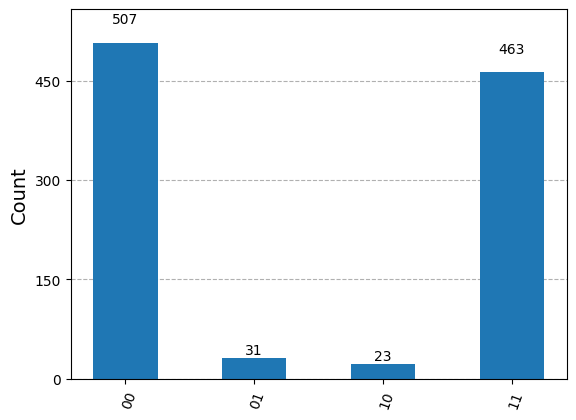

In [6]:
counts = result[0].data.meas.get_counts()
plot_histogram(counts)